# Partitioned Sampling Tests: 

In [ ]:
# using Distributed 
# addprocs(3)

In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests

In [2]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using Revise
using BAT

┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b-ab80aecada7e]
└ @ Base loading.jl:1260


## 1. BAT model definition: Gaussian mixture

Let us use a mixture of 4 normal distribution with random  covariance matrices as a model: 

In [4]:
JLD2.@load "../data/mixture-9D-nc.jld" means cov_m n_clusters

mixture_model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters]);

likelihood = let model = mixture_model
    params -> begin
         return LogDVal(logpdf(model, params.a))
    end
end

prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:size(means)[2]])
posterior = PosteriorDensity(likelihood, prior);
log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

47.684856298932324

In [ ]:
# # Caushy Distribution: 

# true_param =(μ1=1, μ2=-1, σ=0.2)

# function fun(x; true_param=true_param)
#     tmp = 1
#     for i in eachindex(x)
#         if i > 2
#             tmp *= pdf(Cauchy(true_param.μ1 + true_param.μ2, true_param.σ), x[i])
#         else 
#             tmp *= 0.5*pdf(Cauchy(true_param.μ1, true_param.σ), x[i]) + 0.5*pdf(Cauchy(true_param.μ2, true_param.σ), x[i])
#         end
#     end
#     return tmp
# end

# #Gausian Shell: 

# function fun(x)
# 	z_o = zeros(length(x))
# 	true_param = (λ=z_o, r=10, σ=5)
#     abs_dist = sqrt(sum((z_o .- x).^2))
#     ll =  exp(-(abs_dist - true_param.r)^2/(2*true_param.σ^2)) / sqrt(2 * pi * true_param.σ^2) 
#     return ll
# end


# # prior = NamedTupleDist(a = [Uniform(-50,50) for i in 1:12]);
# # prior = NamedTupleDist(a = [Normal(0, 10) for i in 1:15])

# posterior = PosteriorDensity(likelihood, prior);
# log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

## 2. Sampling: 

In [5]:
sampler = MetropolisHastings() # AHMC()

burnin_1 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 10000,
        max_nsteps_per_cycle = 10000,
        max_time_per_cycle = 25,
        max_ncycles = 40
    )

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.05..0.15,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5
)

sampling_kwargs = (burnin = burnin_1, tuning=tuning);

The same with exploration sampler

In [6]:
# MetropolisHastings: 
exploration_sampler = MetropolisHastings()

burnin_2 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 6000,
        max_nsteps_per_cycle = 6000,
        max_time_per_cycle = 25,
        max_ncycles = 20
    )

exploration_kwargs = (burnin = burnin_2,)
n_exploration = (10^2, 40);

Space partitioning can be done using `BAT.KDTreePartitioning` algorithm

In [7]:
partitioner = KDTreePartitioning(
        partition_dims = :auto, # dimension indices that are considered for partition
        extend_bounds=true # "false" is appropriate for debugging, very fast tuning /convergence 
    );

To integrate subspaces, any `BAT.IntegrationAlgorithm` can be used: 

In [8]:
integrator = AHMIntegration(  
        whitening= CholeskyPartialWhitening(), #CholeskyPartialWhitening(),
        autocorlen= GeyerAutocorLen(),
        volumetype = :HyperRectangle,
        max_startingIDs = 10000,
        max_startingIDs_fraction = 2.5,
        rect_increase = 0.1,
        warning_minstartingids = 16,
        dotrimming = true,
        uncertainty= [:cov]
    );

In [9]:
algorithm = PartitionedSampling(
        sampler = sampler,
        exploration_sampler = exploration_sampler,
        partitioner = partitioner,
        integrator = integrator,
        exploration_kwargs = exploration_kwargs,
        sampling_kwargs = sampling_kwargs,
        n_exploration = n_exploration
    );

In [ ]:
n_chains = 10 # chains per subspace 
n_samples = 15*10^5 # samples per subspace 
n_subspaces = 1

output_sp_ms = bat_sample(posterior, (n_samples, n_chains, n_subspaces), algorithm);

samples_3 = output_sp_ms.result;

┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:71
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 40 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 40 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 40 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 40 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 40 chains, 6 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info:

In [ ]:
# using HDF5
# bat_write("test.hdf5", unshaped.(samples_3))
# outp = bat_read("test.hdf5")
# samples_3_tmp = varshape(samples_3).(outp);

In [ ]:
# using CSV
# CSV.write("table_tmp.csv", output_sp_ms.info)
# csvfile = CSV.File("table_tmp.csv")
# tt = Table(csvfile)

# Measurements.measurement(parse.(Float64, split(tt.density_integral[1], " ± "))...)
# UnitRange(parse.(Int64, split(tt.integration_wc[1], ":"))...)

In [11]:
posterior_integral = -log(sum(output_sp_ms.info.density_integral))

47.219 ± 0.077

In [12]:
flat_bounds = BAT.get_tree_par_bounds(output_sp_ms.part_tree);

In [13]:
@show log(sum([prod(rec_bound[:,2] .- rec_bound[:,1]) for rec_bound in flat_bounds]))
@show log_volume;

log(sum([prod(rec_bound[:, 2] .- rec_bound[:, 1]) for rec_bound = flat_bounds])) = 47.68485629893233
log_volume = 47.684856298932324


┌ Warning: var will default to corrected=true in the future. Use corrected=false for previous behaviour.
│   caller = ip:0x0
└ @ Core :-1


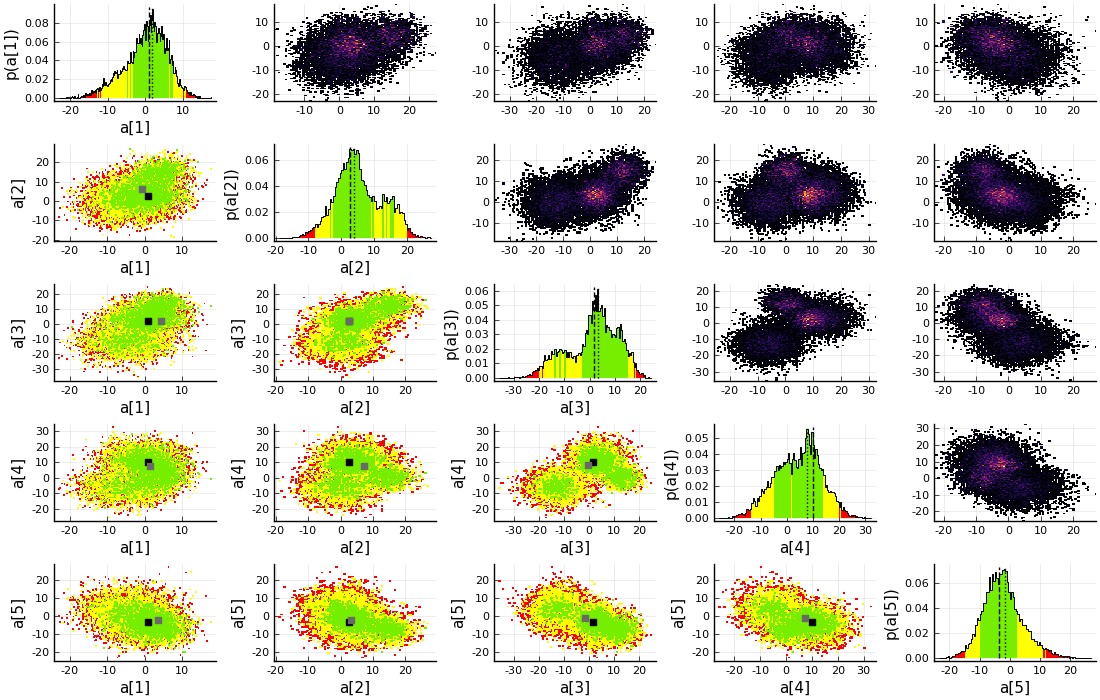

In [14]:
plot(samples_3, vsel=[1,2,3,4,5], size=(1100,700), globalmode=true, localmode=true, 
    upper=Dict("partition_tree"=>output_sp_ms.part_tree, 
        "mean"=>false, "globalmode"=>false, "localmode"=>false,),
)

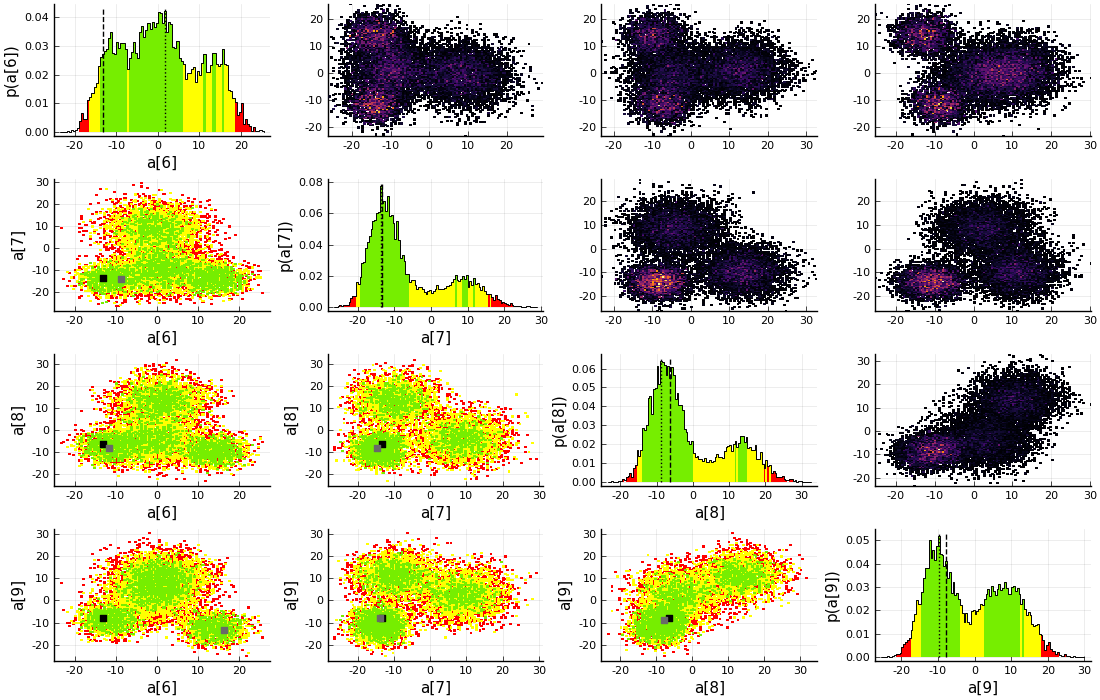

In [15]:
plot(samples_3, vsel=[6,7,8,9,10], size=(1100,700), globalmode=true, localmode=true, 
    upper=Dict("partition_tree"=>output_sp_ms.part_tree, "mean"=>false, "globalmode"=>false, "localmode"=>false,))

## Test Single Subspaces: 

In [ ]:
subs_ind = 3
smpl_ind = output_sp_ms.info.samples_ind[subs_ind]
smpl_tot_weight = output_sp_ms.info.sum_weights[subs_ind]
smpl_trunc = samples_3[smpl_ind]
smpl_int = output_sp_ms.info.density_integral[subs_ind].val

samples_tmp = DensitySampleVector((smpl_trunc.v,
            smpl_trunc.logd,
            round.(Integer, smpl_tot_weight .* smpl_trunc.weight ./ smpl_int),
            smpl_trunc.info,
            smpl_trunc.aux));


integral_val, hmi_data = bat_integrate(samples_tmp, integrator)

@show smpl_int, integral_val

In [ ]:
typeof(smpl_trunc.v[1])

In [ ]:
exp(log(integral_val) + log_volume)

In [ ]:
plot(samples_tmp, upper=Dict("partition_tree"=>output_sp_ms.part_tree, 
        "mean"=>false, "globalmode"=>false, "localmode"=>false))

In [ ]:
# plot(hmi_data, dim1 = 1, dim2 = 2, size=(900,450), plot_seedcubes=false, plot_rejectedrects = false, plot_acceptedrects = true, legend=false)

## Resample Subspace: 

In [ ]:
smpl_int = output_sp_ms.info.density_integral[subs_ind]

flat_bounds = BAT.get_tree_par_bounds(output_sp_ms.part_tree)[subs_ind]

iid_samples = bat_sample(NamedTupleDist(a=mixture_model), 10^6).result;

In [ ]:
mask_iid = [prod(flat_bounds[:,1] .< s.v[1][1] .<  flat_bounds[:,2]) for s in iid_samples]

@show sum(mask_iid)

In [ ]:
integral_val_iid, hmi_data_iid = bat_integrate(iid_samples[mask_iid], integrator);

In [ ]:
integral_val_iid

In [ ]:
exp(log(smpl_int) + log_volume)

In [ ]:
plot(iid_samples[mask_iid], upper=Dict("partition_tree"=>output_sp_ms.part_tree, 
        "mean"=>false, "globalmode"=>false, "localmode"=>false))

## MCMC samples: 

In [ ]:
output_mcmc = bat_sample(posterior, (10^5, 5), MetropolisHastings()).result;

In [ ]:
plot(output_mcmc, vsel=[1,2,3,4,5], size=(700,700), globalmode=true, localmode=true, 
    upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false))

In [ ]:
log(bat_integrate(output_mcmc).result)

# IID Samples: 

In [ ]:
iid_samples =  bat_sample(NamedTupleDist(a=mixture_model), 10^6).result;

In [ ]:
plot(iid_samples)